# Basic Calculus
## Numerically differentiating and integrating

In this notebook you will learn how to differentiate and integrate _numerically_. Your first question might be, "Why? Since I know how to differentiate and integrate functions already." The simple answer is that the "function" you are integrating may be the result of complex previous calculations and therefore come in the form of an array, not a function.

## Step 1 - Discretizing a function.

We already did this step when we made plots. Often one of the first steps in solving a problem numerically is to _discretize_ the problem. (See [Discretization](https://en.wikipedia.org/wiki/Discretization)). At the most basic level, discretization involves choosing a starting point, an ending point and a step size. It seems easy enough, but there are _a lot_ of subtleties in this step. How small should the step size be? What starting point and ending point are safe? Both are especially problematic when working on a problem that goes from $-\infty$ to $\infty$, and is computationally intense! Any choice of discretization will introduce a discretization error. In advanced computational systems, often the step size is not constant, leading to "meshes". Though all this is complicated, we will not be spending time on these details.

### Discretization and scaling

One detail that we _do_ want to pay attention to: if you chose your start point, end point and step size correctly, your numerical answer will not change significantly if you change the choices by a small amount. Especially the step size can be sensitive. Often what is done is to choose a step size, do the computation, and then repeat it with a step size half as large. If the two computations agree, most likely little will be gained from going to an even smaller step size.

Here is a simple example. We take the $\cos(\theta)$ function and discretize it with different choices of step sizes and then plot the result.

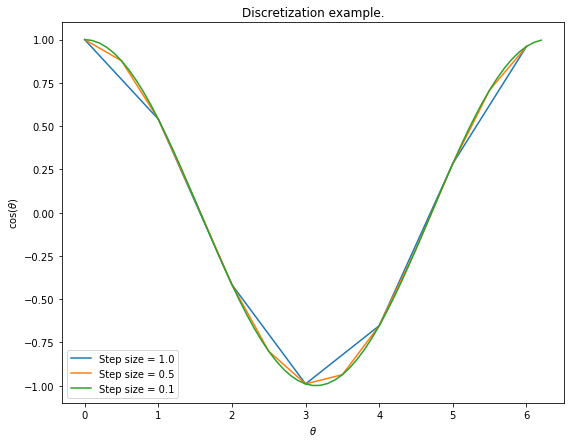

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

fig = plt.figure(figsize=(9,7))
ax  = fig.add_subplot(111)
ax.set_title("Discretization example.")
ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'$\cos(\theta)$')
start = 0.
stop = 2*np.pi
for step_size in [1.,0.5,0.1]:
    x =  np.arange(start,stop,step_size)
    y =  np.cos(x)
    ax.plot(x,y,label="Step size = {}".format(step_size))

# ax.set_xlim(0.2,3.5)  # This allows you to zoom in on only 0.2 to 3.5
ax.legend()

You can clearly see in the plot that a stepsize of 1. is not "horrible" (What whould be? Try >3) we can see that the accuracy of the curve is visibly deteriorated. Even at 0.5 we can see discrete kinks, while at 0.1, _visually_ we seem to be doing OK. It will depend on the calculation we are trying to do whether that is accurate enough.

## Integrating a discretized function

Very often you will need to get the integral of your function over some range. The simplest solution to that is to just sum over all the points in the range and muliply by $\Delta x$, your step size. If you want a plot of the integral, you need to do this over and over for each point on the plot. The formula is:

$$ \int_{x_1}^{x_2} f(x) dx \rightarrow \sum_{i_1}^{i_2} x_i \Delta x $$
Where $x_1$ is the starting point, which corresponds to $x_{i_1}$ in the discretized space, and $x_2$ is the ending point, which corresponds to $x_{i_2}$ in the discretized space.

Let's try this in a brute force loop way, to illustrate the steps. First we compute the $\cos(\theta)$ curves for different steps, but this time we store them in a list. For each of the curve, we compute the integral from the lowest point to $x_i$, and then plot it.

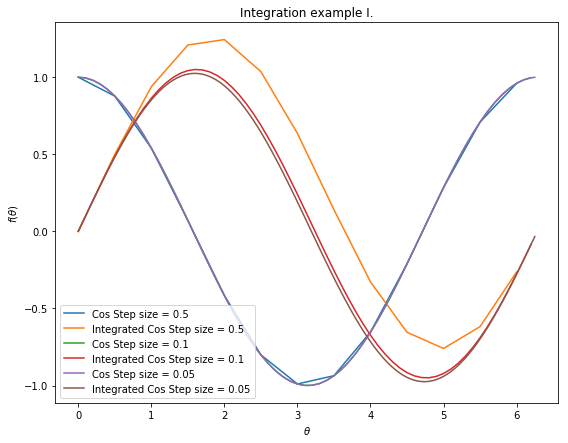

In [2]:
# Again, compute the different cosine approximation

fig = plt.figure(figsize=(9,7))
ax  = fig.add_subplot(111)
ax.set_title("Integration example I.")
ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'$f(\theta)$')
start = 0.
stop = 2*np.pi
steps = [0.5,0.1,0.05]
for step_size in steps:
    x = np.arange(start,stop,step_size)
    y = np.cos(x)
    ax.plot(x,y,label="Cos Step size = {}".format(step_size))

    y_int = np.zeros_like(y)  # An array of zeros the same size as y.
    # Now integrate y for each x:
    for ix in range(len(y)):
        y_sum = np.sum(y[0:ix])*step_size
        y_int[ix] = y_sum

    ax.plot(x,y_int,label="Integrated Cos Step size = {}".format(step_size))

ax.legend()

We can now see how for the stepsize of 0.5 the integration does not look so good, while the original $\cos$ looked fairly good. The difference between 0.1 and 0.05 seems more acceptable.

### Integrating Better

Clearly, you must be able to do better, but how? If you think about the steps of integrating, you could see that instead of simply adding the y values for each step, you could take into account the "trapezoid" of the current step and the next one (see [Trapezoidal rule](https://en.wikipedia.org/wiki/Trapezoidal_rule). You can look up how to program that yourself, but you don't have to because the scipy library already includes it as part of the package [spipy.integrate](https://docs.scipy.org/doc/scipy/reference/tutorial/integrate.html).

There are several function that are part of the scipy.integrate package. If you know the functional form of the function you want to integrate, you can use integrate.quad() or integrate.quadrature or integrate.romberg. If you do not know, but have an array of data, you can use integrate.trapz, integrate.simps or integrate.romb.

So let's try again on our cosine function. Here is the same steps as we used before, but now using the improved algorithms.

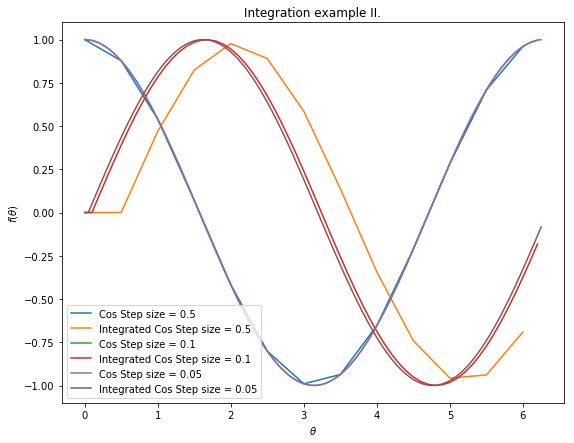

In [3]:
# Again, compute the different cosine approximation
import scipy.integrate as integrate
fig = plt.figure(figsize=(9,7))
ax  = fig.add_subplot(111)
ax.set_title("Integration example II.")
ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'$f(\theta)$')
start = 0.
stop = 2*np.pi
steps = [0.5,0.1,0.05]
for step_size in steps:
    x = np.arange(start,stop,step_size)
    y = np.cos(x)
    ax.plot(x,y,label="Cos Step size = {}".format(step_size))

    y_int = np.zeros_like(y)  # An array of zeros the same size as y.
    # Now integrate y for each x:
    for ix in range(0,len(y)):
        y_sum = integrate.trapz(y[0:ix],x[0:ix]) 
        # The x is given for the steps, which do not need to be equal sized.
        y_int[ix] = y_sum
    ax.plot(x,y_int,label="Integrated Cos Step size = {}".format(step_size))

ax.legend()

Here we note that this does _a little bit_ better for the 0.5 step size, but there is an interesting _feature_ (not a bug): the first step evaluates to zero! The reason for this is that you don't have a trapezoid for the very first step, and as a result the integration curves are all shifted by one. 

The plot looks better if we fix that shift, but then we loose the last point. The code below shows how you do this. 

Since this type of integration: data array in, data array (not just a single number) out, is so common, there is a single step function that you can use: cumtrapz. That routine also takes care of any shifting. On the plot below, those curves are added as well for comparison. You can see that there is a shift (the array is one shorter). Note the curves are on top of each other.

There is another method, called [Simpson's rule](https://en.wikipedia.org/wiki/Simpson%27s_rule) (sometimes called Keppler's rule), which is shown below. The difference is not perceptible for this data.

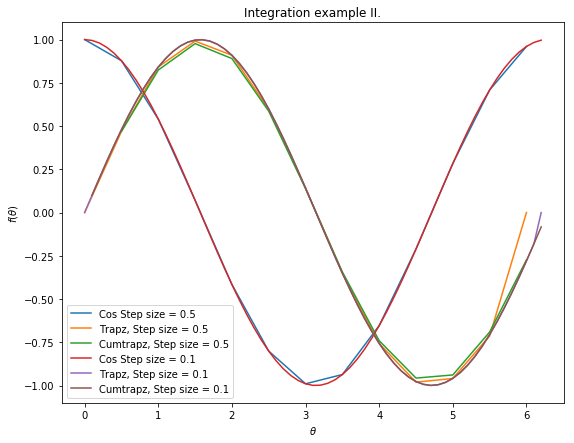

In [4]:
# Again, compute the different cosine approximation
fig = plt.figure(figsize=(9,7))
ax  = fig.add_subplot(111)
ax.set_title("Integration example II.")
ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'$f(\theta)$')
start = 0.
stop = 2*np.pi
steps = [0.5,0.1]
for step_size in steps:
    x = np.arange(start,stop,step_size)
    y = np.cos(x)
    ax.plot(x,y,label="Cos Step size = {}".format(step_size))

    y_int = np.zeros_like(y)  # An array of zeros the same size as y.
    # Now integrate y for each x:
    for ix in range(0,len(y)-1):                      # Because we shift, we are one point short.
        y_sum = integrate.simps(y[0:ix+1],x[0:ix+1])  # NOTE THE SHIFT 
        # The x is given for the steps, which do not need to be equal sized.
        y_int[ix] = y_sum
    ax.plot(x,y_int,label="Trapz, Step size = {}".format(step_size))
    y_int = integrate.cumtrapz(y,x)
    ax.plot(x[1:],y_int,label="Cumtrapz, Step size = {}".format(step_size))

ax.legend()

## Differentiation

Sometimes we want to take the derivative of the data rather than the integral. (Surprisingly, the integral is a far more common operation). From your calculus course, you learned that:

$$ \frac{d}{dx} f(x) = \lim_{\epsilon\rightarrow 0} \frac{f(x+\epsilon) - f(x)}{\epsilon} $$

For a discrete set of point, one cannot have $\epsilon\rightarrow0$, so we are stuck with:

$$ \frac{d}{dx} f(x_i) \approx \frac{\Delta f}{\Delta x} = \frac{ y[i+1] - y[i] }{x[i+1]-x[i]}$$

This is called a _forward_ difference. Since the step size is finite, it is slightly different from a _backward_ difference:

$$ \frac{d}{dx} f(x_i) \approx \frac{\Delta f}{\Delta x} = \frac{ y[i] - y[i-1] }{x[i]-x[i-1]}$$

You can also comput a _central difference_, but since you cannot use steps of $\frac{1}{2}\Delta x$, since that does not exist in our space. The central difference is then a combination of the previous two:
$$
\frac{d}{dx} f(x_i) \approx \frac{y[i+1] - y[i-1]}{x[i+1] - x[i-1]}
$$
This last one is a little more accurate than the first two.

To implement this, we can make a loop that takes differences. A faster way to do the same is to use the features of Numpy.

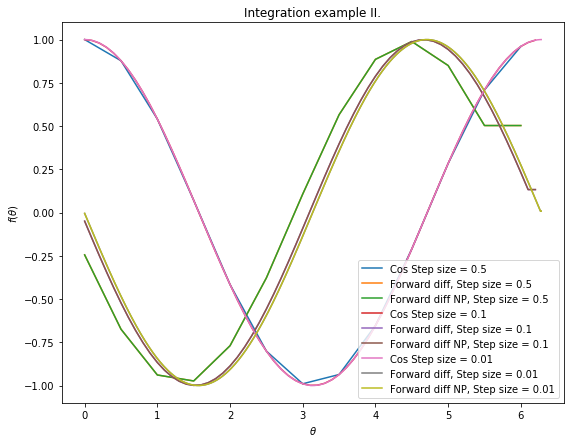

In [5]:
fig = plt.figure(figsize=(9,7))
ax  = fig.add_subplot(111)
ax.set_title("Integration example II.")
ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'$f(\theta)$')
start = 0.
stop = 2*np.pi
steps = [0.5,0.1,0.01]
for step_size in steps:
    x = np.arange(start,stop,step_size)
    y = np.cos(x)
    ax.plot(x,y,label="Cos Step size = {}".format(step_size))

    y_diff = np.zeros_like(y)  # An array of zeros the same size as y.
    # Now take the difference of y for each x:
    for ix in range(0,len(y)-1):                      # Because we shift, we are one point short.
        dy = (y[ix+1]-y[ix]) /(x[ix+1]-x[ix])  # NOTE THE SHIFT 
        # The x is given for the steps, which do not need to be equal sized.
        y_diff[ix] = dy
    y_diff[-1] = (y[-1]-y[-2])/(x[-1]-x[-2])  # Use a backward difference for last point
    ax.plot(x,y_diff,label="Forward diff, Step size = {}".format(step_size))

    # This gives the EXAcT same result as above, but faster.
    dy = np.zeros_like(y)
    dy[0:-1] = np.diff(y)/np.diff(x)
    dy[-1] = (y[-1]-y[-2])/(x[-1]-x[-2])  # Use a backward difference for last point
    ax.plot(x,dy,label="Forward diff NP, Step size = {}".format(step_size))
    
ax.legend()

Note that for the derivative, we get trouble at the end point, even when we try to make the last point as a _backward_ difference.

So how can we do better? The only way to improve the derivate is to improve the _input data_ to the difference equations. There is a method for doing that, which is called "interpolation", which is finding the points _in between_ the ones in the data array by inference. The best that could possibly do would be to return a new array with a smaller step size, so why bother? Well, the interpolation routines are not very computationally expensive, and you may have situations where the input data for your computation is _very_ expensive. Think Lattice QCD.

For a derivative as we coded it up above, a linear interpolation will not do any better than what we started with, since the linear interpolation just connects the dots with a straight line. More complicated methods are well documented, and which is the _best_ one to use depends on the details of the data. Note that in our case, a cosine function is not a very demanding set of input data. 

You will find several methods for interpolation in [scipy.interpolate](https://docs.scipy.org/doc/scipy/reference/interpolate.html). Here we will just look at two methods for 1D interpolation. There are more, and everything can be extended in multiple dimensions.

The two methods we will look at here are "cubic" interpolation and "spline" interpolation.

**Note:** If you are not careful with interpolation, you can get some pretty wild results. You should _always_ check the interpolation step by plotting the results.

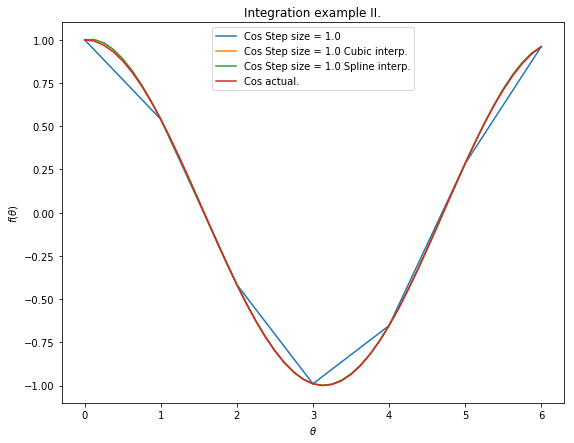

In [6]:
import scipy.interpolate as interpolate

fig = plt.figure(figsize=(9,7))
ax  = fig.add_subplot(111)
ax.set_title("Integration example II.")
ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'$f(\theta)$')
start = 0.
stop = 2*np.pi
steps = [1.0]   # Only one step_size, so the plots don't get too messy.
for step_size in steps:
    x = np.arange(start,stop,step_size)
    y = np.cos(x)
    ax.plot(x,y,label="Cos Step size = {}".format(step_size))
   
    # Cubic interpolation.
    f_interp_c = interpolate.interp1d(x,y,kind="cubic") # This returns a *function* 
    
    x_new = np.arange(start,stop-2./8.,1./8.)  # A step 1/4 the previous size.
    y_new_c = f_interp_c(x_new)
    ax.plot(x_new,y_new_c,label="Cos Step size = {} Cubic interp.".format(step_size))
    # Spline interpolation
    spline_rep = interpolate.splrep(x,y)
    y_new_s = interpolate.splev(x_new,spline_rep)
    ax.plot(x_new,y_new_s,label="Cos Step size = {} Spline interp.".format(step_size))
    ax.plot(x_new,np.cos(x_new),label="Cos actual.".format(step_size))
    
ax.legend()

What we see is that we get remarkably close to the actual curve of a cosine. This will not always be the case. A sine or cosine type curve shape is easier to interpolate than some other functional forms. You should try other functions on your own.

We can now take the derivatives. It should be no surprise that these are much better for the interpolated data, as if the step size of the original was much smaller.

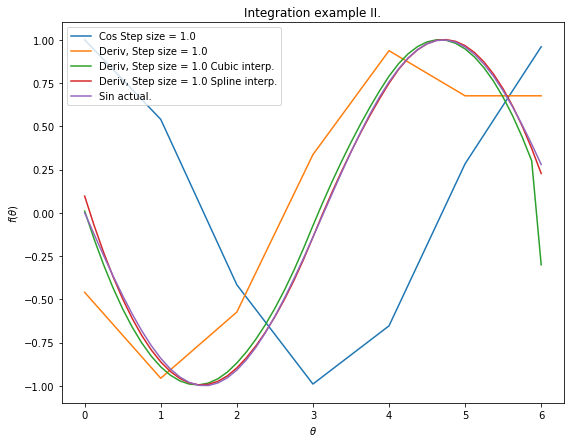

In [7]:
fig = plt.figure(figsize=(9,7))
ax  = fig.add_subplot(111)
ax.set_title("Integration example II.")
ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'$f(\theta)$')
start = 0.
stop = 2*np.pi
steps = [1.0]
for step_size in steps:
    x = np.arange(start,stop,step_size)
    y = np.cos(x)
    ax.plot(x,y,label="Cos Step size = {}".format(step_size))
 
    dy = np.zeros_like(y)
    dy[0:-1] = np.diff(y)/np.diff(x)
    dy[-1] = (y[-1]-y[-2])/(x[-1]-x[-2])  # Use a backward difference for last point
    ax.plot(x,dy,label="Deriv, Step size = {}".format(step_size))

    # Cubic interpolation.
    f_interp_c = interpolate.interp1d(x,y,kind="cubic") # This returns a *function* 
    
    x_new = np.arange(start,stop-2./8.,1./8.)  # A step 1/4 the previous size.
    y_new_c = f_interp_c(x_new)
    dy_new_c = np.zeros_like(x_new)
    dy_new_c[0:-1] = np.diff(y_new_c)/np.diff(x_new)
    dy_new_c[-1] = (y_new_c[-1] - y_new_c[-2])/(x_new[-2]-x_new[-1])
    ax.plot(x_new,dy_new_c,label="Deriv, Step size = {} Cubic interp.".format(step_size))
    # Spline interpolation
    spline_rep = interpolate.splrep(x,y)
    dy_new_s = interpolate.splev(x_new,spline_rep,der=1) # First derivative in one step!
    ax.plot(x_new,dy_new_s,label="Deriv, Step size = {} Spline interp.".format(step_size))
    ax.plot(x_new, -np.sin(x_new),label="Sin actual.".format(step_size))
    
ax.legend()  # Simple difference.



What you see from these results is that both the cubic interpolation and the spline do very well. For the last point, the spline routine does better, since the internal routines are better handling the end points.